# Generate `pdbqt` files

Use `AutoDockTools` python package and MGLTools' `prepare_receptor4.py` python script to generate pdbqt files.

## Resources

* https://www.scripps.edu/sanner/python/molkit/molkitoverview.html
* https://github.com/insilichem/gaudi/blob/master/gaudi/objectives/vina.py
* http://mgltools.scripps.edu/api/AutoDockTools/AutoDockTools.MoleculePreparation.AD4ReceptorPreparation-class.html

## Main `pdbqt` generating tools

### `AutoDockTools` python package
`conda install -c insilichem autodocktools-prepare`

### MGLTools
http://mgltools.scripps.edu/downloads/mgltools-downloads-page/?searchterm=os

`mgltools_x86_64Linux2_1.5.6.tar.gz`

## Installation

Install `adt` conda environment:

`conda env create -f environement.yml`

## Imports

In [1]:
import glob
import logging
import pickle
import sys

from AutoDockTools.MoleculePreparation import AD4ReceptorPreparation
import matplotlib.pyplot as plt
import MolKit
import pandas as pd
from pathlib import Path

## Functions

In [2]:
def read_pdbqt(file_path):
    
    """
    Reads pdbqt file as DataFrame.
    
    Parameters
    ----------
    file_path : String
        Path to pdbqt file.
    
    """

    f = open(str(Path(file_path).resolve()))
    
    # Split lines
    lines = [i[:-1].split() for i in f.readlines()]
    
    # Make sure to only include ATOM and HETATM lines
    lines = [i for i in lines if i[0] in ['ATOM', 'HETATM']]
    
    # Check if all lines have same number of columns
    if len(set([len(i) for i in lines])) is not 1:
        print('Error: Check file manually, number of columns not equal for all lines.')
        
    # Cast columns for numbers to floats      
    df = pd.DataFrame(lines, 
                      columns=[
                          'record_type',
                          'atom_serial_number',
                          'atom_name',
                          'residue_name',
                          'chain_identifier',
                          'residue_sequence_number',
                          'x',
                          'y',
                          'z',
                          'occupancy',
                          'bfactor',
                          'partial_charges',
                          'AutoDock4_atom_types'
                      ])
    
    df['x'] = df['x'].astype(float)
    df['y'] = df['y'].astype(float)
    df['z'] = df['z'].astype(float)
    df['partial_charges'] = df['partial_charges'].astype(float)
    
    return df

In [3]:
def get_df_diff(file_path1, file_path2):
    
    """
    Read two pdbqt files as DataFrames, compare DataFrames, and result differing rows.
    
    Parameters
    ----------
    file_path1, file_path2 : string
        Path to pdbqt file.
        
    Returns
    -------
    DataFrame
        Differing rows in two input files.
    
    """
    
    # Read pdbqt files to be compared
    p1 = read_pdbqt(file_path1)
    p2 = read_pdbqt(file_path2)

    # Compare
    p1_diff = pd.concat([p1,p2,p2]).drop_duplicates(keep=False)
    p2_diff = pd.concat([p1,p1,p2]).drop_duplicates(keep=False)

    return p1_diff, p2_diff

In [4]:
def generate_pdbqt(receptor_path):
    
    """
    Generate pdbqt file for a receptor file in pdb or mol2 file format.
    
    Parameters
    ----------
    receptor_path : string
        Path to receptor file, e.g. pdb or mol2 format.
    
    """
    
    # Set input path
    pdb_path = Path(receptor_path).resolve()

    # Read pdb file
    mk = MolKit.Read(str(pdb_path))
    mol = mk[0]

    # Build bonds using atomic distances
    mol.buildBondsByDistance()
    
    # Set output path
    pdbqt_path = (pdb_path.parent / Path(pdb_path.stem + '_adt')).with_suffix(pdb_path.suffix + 'qt')
    print(pdbqt_path)

    # Add Gasteiger charges
    # Defaults: charges_to_add='gasteiger', repairs='checkhydrogens'
    AD4ReceptorPreparation(mol, outputfilename=str(pdbqt_path))
    

## Example pdb file

Before I use `generate_pdbqt`, I will go over the steps using an example pdb file to demonstrate how I ended up with the setup I am using now in `generate_pdbqt`.

### 1. Read pdb file

In [5]:
# Set input path
pdb_path = Path('data/1a0iA.pdb').resolve()

# Read pdb file
mk = MolKit.Read(str(pdb_path))
mol = mk[0]

# Build bonds using atomic distances
mol.buildBondsByDistance()

[<Bond instance '1a0iA:A:ASN101:CG == 1a0iA:A:ASN101:OD1','None'>,
 <Bond instance '1a0iA:A:ASN101:CG == 1a0iA:A:ASN101:ND2','None'>,
 <Bond instance '1a0iA:A:ASP99:CG == 1a0iA:A:ASP99:OD2','None'>,
 <Bond instance '1a0iA:A:ASP99:CG == 1a0iA:A:ASP99:OD1','None'>,
 <Bond instance '1a0iA:A:ASN101:CB == 1a0iA:A:ASN101:CG','None'>,
 <Bond instance '1a0iA:A:THR102:CB == 1a0iA:A:THR102:OG1','None'>,
 <Bond instance '1a0iA:A:THR102:CB == 1a0iA:A:THR102:CG2','None'>,
 <Bond instance '1a0iA:A:ASN101:C == 1a0iA:A:ASN101:O','None'>,
 <Bond instance '1a0iA:A:ASN101:C == 1a0iA:A:THR102:N','None'>,
 <Bond instance '1a0iA:A:ASN101:CA == 1a0iA:A:ASN101:CB','None'>,
 <Bond instance '1a0iA:A:ASN101:CA == 1a0iA:A:ASN101:C','None'>,
 <Bond instance '1a0iA:A:THR102:N == 1a0iA:A:THR102:CA','None'>,
 <Bond instance '1a0iA:A:ASP124:CA == 1a0iA:A:ASP124:CB','None'>,
 <Bond instance '1a0iA:A:ASP124:CA == 1a0iA:A:ASP124:C','None'>,
 <Bond instance '1a0iA:A:LYS123:CA == 1a0iA:A:LYS123:CB','None'>,
 <Bond instance

### 2. Generate pdbqt file (using `AutoDockTools.MoleculePreparation.AD4ReceptorPreparation`)

#### a. Using `AD4ReceptorPreparation` (as in MGLTools `prepare_receptor4.py` script)

In [6]:
# Set output path
pdbqt_path = (pdb_path.parent / Path(pdb_path.stem + '_adt')).with_suffix(pdb_path.suffix + 'qt')

# Add Gasteiger charges
# Defaults: charges_to_add='gasteiger', repairs='checkhydrogens'
AD4ReceptorPreparation(mol, outputfilename=str(pdbqt_path))

adding gasteiger charges to peptide


<AutoDockTools.MoleculePreparation.AD4ReceptorPreparation instance at 0x7f1c09f40f38>

#### b. Using an instance of `AD4ReceptorPreparation`

In [7]:
# Set output path
pdbqt_path = (pdb_path.parent / Path(pdb_path.stem + '_adt2')).with_suffix(pdb_path.suffix + 'qt')

# Add Gasteiger charges
# Defaults: charges_to_add='gasteiger', repairs='checkhydrogens'
preparer = AD4ReceptorPreparation
preparer(mol, outputfilename=str(pdbqt_path))

adding gasteiger charges to peptide


<AutoDockTools.MoleculePreparation.AD4ReceptorPreparation instance at 0x7f1c03eae0e0>

In [8]:
!diff data/1a0iA_adt.pdbqt data/1a0iA_adt2.pdbqt

1,6c1,6
< ATOM      1  N   VAL A   1     -10.053  -6.552  67.853  1.00  0.00    -0.066 N 
< ATOM      2  HN1 VAL A   1      -9.830  -6.699  68.837  1.00  0.00     0.275 HD
< ATOM      3  HN2 VAL A   1      -9.637  -5.690  67.501  1.00  0.00     0.275 HD
< ATOM      4  HN3 VAL A   1      -9.564  -7.219  67.256  1.00  0.00     0.275 HD
< ATOM      5  CA  VAL A   1     -11.496  -6.584  67.619  1.00  0.00     0.278 C 
< ATOM      6  C   VAL A   1     -12.002  -7.947  68.142  1.00  0.00     0.249 C 
---
> ATOM      1  N   VAL A   1     -10.053  -6.552  67.853  1.00  0.00    -0.058 N 
> ATOM      2  HN1 VAL A   1      -9.830  -6.699  68.837  1.00  0.00     0.276 HD
> ATOM      3  HN2 VAL A   1      -9.637  -5.690  67.501  1.00  0.00     0.276 HD
> ATOM      4  HN3 VAL A   1      -9.564  -7.219  67.256  1.00  0.00     0.276 HD
> ATOM      5  CA  VAL A   1     -11.496  -6.584  67.619  1.00  0.00     0.255 C 
> ATOM      6  C   VAL A   1     -12.002  -7.947  68.142  1.00  0.00     0.259 C 
8,14

> ATOM   2772  CG  GLU A 281       9.594 -39.548  37.973  1.00  0.00     0.100 C 
> ATOM   2773  CD  GLU A 281       8.482 -38.496  38.084  1.00  0.00     0.185 C 
> ATOM   2774  OE1 GLU A 281       8.526 -37.476  37.380  1.00  0.00    -0.647 OA
> ATOM   2775  OE2 GLU A 281       7.560 -38.709  38.873  1.00  0.00    -0.647 OA
> ATOM   2776  N   PHE A 282      13.346 -38.212  37.108  1.00  0.00    -0.337 N 
> ATOM   2777  HN  PHE A 282      13.268 -37.644  37.951  1.00  0.00     0.164 HD
> ATOM   2778  CA  PHE A 282      14.058 -37.645  35.964  1.00  0.00     0.164 C 
> ATOM   2779  C   PHE A 282      15.298 -38.436  35.558  1.00  0.00     0.251 C 
2781,2794c2781,2794
< ATOM   2781  CB  PHE A 282      14.494 -36.210  36.258  1.00  0.00     0.073 C 
< ATOM   2782  CG  PHE A 282      13.359 -35.215  36.371  1.00  0.00    -0.056 A 
< ATOM   2783  CD1 PHE A 282      12.072 -35.530  35.931  1.00  0.00     0.007 A 
< ATOM   2784  CD2 PHE A 282      13.627 -33.970  36.915  1.00  0.00     0.007

Using an instance generates different partial charges than using the class directly. Since MGLTools' `prepare_receptor4.py` uses the class directly, I will follow that example for now (since it also generates almost the same pdbqt files as provided with the TOUGH-M1 dataset as we will see in the following).

### 3. Generate pdbqt file (using MGLTools' `prepare_receptor4.py`)

In [9]:
# Run MGLTools
!/home/dominique/anaconda2/envs/adt/bin/python /opt/mgltools_x86_64Linux2_1.5.6/MGLToolsPckgs/AutoDockTools/Utilities24/prepare_receptor4.py -r data/1a0iA.pdb -o data/1a0iA_mgl.pdbqt -A checkhydrogens

swig/python detected a memory leak of type 'BHtree *', no destructor found.
adding gasteiger charges to peptide


### 4. Compare pdbqt files

In [10]:
!diff data/1a0iA.pdbqt data/1a0iA_adt.pdbqt

327c327
< ATOM    327  N   ASP A  35       2.849 -27.390  55.479  1.00  0.00    -0.346 N 
---
> ATOM    327  N   ASP A  35       2.849 -27.390  55.479  1.00  0.00    -0.345 N 
3010c3010
< ATOM   3010  N   ASP A 306      15.164 -32.138  26.312  1.00  0.00    -0.346 N 
---
> ATOM   3010  N   ASP A 306      15.164 -32.138  26.312  1.00  0.00    -0.345 N 


Intestingly, both the nitrogen in ASP.

In [11]:
!diff data/1a0iA.pdbqt data/1a0iA_mgl.pdbqt

327c327
< ATOM    327  N   ASP A  35       2.849 -27.390  55.479  1.00  0.00    -0.346 N 
---
> ATOM    327  N   ASP A  35       2.849 -27.390  55.479  1.00  0.00    -0.345 N 
3010c3010
< ATOM   3010  N   ASP A 306      15.164 -32.138  26.312  1.00  0.00    -0.346 N 
---
> ATOM   3010  N   ASP A 306      15.164 -32.138  26.312  1.00  0.00    -0.345 N 


In [12]:
!diff data/1a0iA_adt.pdbqt data/1a0iA_mgl.pdbqt

## Check other examples

Generate for other pdb examples pdbqt using `generate_pdbqt` and check if the result differs from pdbqt files provided by TOUGH-M1.

In [13]:
generate_pdbqt('data/1a0jC.pdb')

/home/dominique/Documents/projects/ratar-data/scripts/pdbqt/data/1a0jC_adt.pdbqt
adding gasteiger charges to peptide


In [14]:
!diff data/1a0jC.pdbqt data/1a0jC_adt.pdbqt

In [15]:
generate_pdbqt('data/1bdoA.pdb')

/home/dominique/Documents/projects/ratar-data/scripts/pdbqt/data/1bdoA_adt.pdbqt
adding gasteiger charges to peptide


In [16]:
!diff data/1bdoA.pdbqt data/1bdoA_adt.pdbqt

## Check TOUGH-M1 dataset

In [17]:
p = Path('/home/dominique/Documents/data/benchmarking/TOUGH-M1/structures/')

In [18]:
pdb_files = [i / Path(i.parts[-1] + '.pdb') for i in list(p.glob('*'))]
pdb_files[:3]

[PosixPath('/home/dominique/Documents/data/benchmarking/TOUGH-M1/structures/4drjA/4drjA.pdb'),
 PosixPath('/home/dominique/Documents/data/benchmarking/TOUGH-M1/structures/3co8A/3co8A.pdb'),
 PosixPath('/home/dominique/Documents/data/benchmarking/TOUGH-M1/structures/4y3bB/4y3bB.pdb')]

In [20]:
def get_pdbqt_diffs(pdb_files):
    
    """
    Get list of pdb ids for which pdbqt files differ between TOUGH-M1 and my data.
    
    Parameters
    ----------
    pdb_files : List of PosixPaths
        List of paths to pdb files.
        
    Results
    -------
    List of strings
        List of pdb ids.
    
    """
    
    pdb_differences = []

    for pdb_file in pdb_files:

        # Generate pdbqt files
        generate_pdbqt(str(pdb_file))

        # Check difference to TOUGH-M1 pdbqt files
        p1_diff, p2_diff = get_df_diff(pdb_file.with_suffix(suffix=pdb_file.suffix + 'qt'), 
                           pdb_file.parent / Path(pdb_file.stem + '_adt.pdbqt'))


        if (not p1_diff.empty) or (not p2_diff.empty):
            print('Difference!')
            pdb_differences.append(pdb_file)
            
    return pdb_differences

In [25]:
# Check at the example of 100 pdb files
#pdb_differences = get_pdbqt_diffs(pdb_files[:100])

/home/dominique/Documents/data/benchmarking/TOUGH-M1/structures/4drjA/4drjA_adt.pdbqt
adding gasteiger charges to peptide
/home/dominique/Documents/data/benchmarking/TOUGH-M1/structures/3co8A/3co8A_adt.pdbqt
adding gasteiger charges to peptide
Difference!
/home/dominique/Documents/data/benchmarking/TOUGH-M1/structures/4y3bB/4y3bB_adt.pdbqt
adding gasteiger charges to peptide
/home/dominique/Documents/data/benchmarking/TOUGH-M1/structures/2f8jA/2f8jA_adt.pdbqt
adding gasteiger charges to peptide
/home/dominique/Documents/data/benchmarking/TOUGH-M1/structures/7aatA/7aatA_adt.pdbqt
adding gasteiger charges to peptide
/home/dominique/Documents/data/benchmarking/TOUGH-M1/structures/4pr3B/4pr3B_adt.pdbqt
adding gasteiger charges to peptide
/home/dominique/Documents/data/benchmarking/TOUGH-M1/structures/3paeB/3paeB_adt.pdbqt
adding gasteiger charges to peptide
Difference!
/home/dominique/Documents/data/benchmarking/TOUGH-M1/structures/4r88A/4r88A_adt.pdbqt
adding gasteiger charges to peptide


adding gasteiger charges to peptide
/home/dominique/Documents/data/benchmarking/TOUGH-M1/structures/1p77A/1p77A_adt.pdbqt
adding gasteiger charges to peptide
/home/dominique/Documents/data/benchmarking/TOUGH-M1/structures/4xnwA/4xnwA_adt.pdbqt
adding gasteiger charges to peptide
/home/dominique/Documents/data/benchmarking/TOUGH-M1/structures/2c9kA/2c9kA_adt.pdbqt
adding gasteiger charges to peptide
/home/dominique/Documents/data/benchmarking/TOUGH-M1/structures/4gi2B/4gi2B_adt.pdbqt
adding gasteiger charges to peptide
/home/dominique/Documents/data/benchmarking/TOUGH-M1/structures/2qkmF/2qkmF_adt.pdbqt
adding gasteiger charges to peptide
/home/dominique/Documents/data/benchmarking/TOUGH-M1/structures/3gdlB/3gdlB_adt.pdbqt
adding gasteiger charges to peptide
/home/dominique/Documents/data/benchmarking/TOUGH-M1/structures/3if2A/3if2A_adt.pdbqt
adding gasteiger charges to peptide
Difference!
/home/dominique/Documents/data/benchmarking/TOUGH-M1/structures/2osuB/2osuB_adt.pdbqt
adding gaste

In [26]:
len(pdb_differences)

23

In [29]:
pickle.dump('pdb_differences', open('data/toughm1_new_differences.p', 'wb'))

### Examples for differences

In [30]:
pdbs = ['3co8A', '2vouA']

In [31]:
# Choose pdb file to investigate
#pdb = pdbs[0]
pdb = pdbs[1]

In [32]:
# Load pdbqt files
p1 = read_pdbqt('/home/dominique/Documents/data/benchmarking/TOUGH-M1/structures/'+pdb+'/'+pdb+'_adt.pdbqt')
p2 = read_pdbqt('/home/dominique/Documents/data/benchmarking/TOUGH-M1/structures/'+pdb+'/'+pdb+'.pdbqt')

In [33]:
def remove_rows(df, ix):
    
    """
    Remove rows from DataFrame.
    
    Parameters
    ----------
    df : DataFrame
        DataFrame.
    ix : list
        List of indices that exist in DataFrame.
    
    Returns
    -------
    DataFrame
        Reduced DataFrame.
        
    """
    
    print(df.shape)
    df.drop(index=ix, inplace=True)
    print(df.shape)
    return df

#### 1. Difference in atoms

* Example `3co8A`: No differences.
* Example `2vouA`: LYS 320 is not present in TOUGH-M1 pdbqt though present in pdb file. This also adds/removes hydrogens on residue 321, since the removal of 320 creates a N-terminus at 321.

In [34]:
p1_const = p1.iloc[:, [0,2,3,4,5]]
p2_const = p2.iloc[:, [0,2,3,4,5]]

p1_diff = pd.concat([p1_const,p2_const,p2_const]).drop_duplicates(keep=False)
p2_diff = pd.concat([p1_const,p1_const,p2_const]).drop_duplicates(keep=False)

In [35]:
p1.iloc[p1_diff.index, :]

,record_type,atom_serial_number,atom_name,residue_name,chain_identifier,residue_sequence_number,x,y,z,occupancy,bfactor,partial_charges,AutoDock4_atom_types
2986,ATOM,2987,N,LYS,A,320,37.348,101.791,31.653,1.00,0.00,-0.346,N
2987,ATOM,2988,HN,LYS,A,320,37.034,101.874,32.620,1.00,0.00,0.163,HD
2988,ATOM,2989,CA,LYS,A,320,38.709,102.228,31.320,1.00,0.00,0.176,C
2989,ATOM,2990,C,LYS,A,320,39.467,101.002,30.831,1.00,0.00,0.241,C
2990,ATOM,2991,O,LYS,A,320,40.250,101.064,29.877,1.00,0.00,-0.271,OA
2991,ATOM,2992,CB,LYS,A,320,39.389,102.802,32.563,1.00,0.00,0.035,C
2992,ATOM,2993,CG,LYS,A,320,40.757,103.471,32.349,1.00,0.00,0.004,C
2993,ATOM,2994,CD,LYS,A,320,41.450,103.739,33.698,1.00,0.00,0.027,C
2994,ATOM,2995,CE,LYS,A,320,42.400,102.583,34.121,1.00,0.00,0.229,C
2995,ATOM,2996,NZ,LYS,A,320,43.758,102.526,33.287,1.00,0.00,-0.079,N


In [36]:
p2.iloc[p2_diff.index, :]

,record_type,atom_serial_number,atom_name,residue_name,chain_identifier,residue_sequence_number,x,y,z,occupancy,bfactor,partial_charges,AutoDock4_atom_types
2987,ATOM,2988,HN1,ALA,A,321,39.472,100.230,32.394,1.00,0.00,0.275,HD
2988,ATOM,2989,HN2,ALA,A,321,38.183,99.781,31.406,1.00,0.00,0.275,HD
2989,ATOM,2990,HN3,ALA,A,321,39.341,100.577,30.751,1.00,0.00,0.275,HD


In [37]:
print('p1')
p1 = remove_rows(p1, p1_diff.index)
print('p2')
p2 = remove_rows(p2, p2_diff.index)

p1
(3705, 13)
(3691, 13)
p2
(3694, 13)
(3691, 13)


#### 2. Difference in coordinates

* Example `3co8A`: No differences.
* Example `2vouA`: Hydrogens that are slightly different in location.

In [38]:
p1_const = p1.iloc[:, 2:9]
p2_const = p2.iloc[:, 2:9]

p1_diff = pd.concat([p1_const,p2_const,p2_const]).drop_duplicates(keep=False)
p2_diff = pd.concat([p1_const,p1_const,p2_const]).drop_duplicates(keep=False)

In [39]:
p1_diff

,atom_name,residue_name,chain_identifier,residue_sequence_number,x,y,z
24,HG1,THR,A,3,52.025,91.252,14.941
201,1HH1,ARG,A,24,37.237,82.075,22.343
202,2HH1,ARG,A,24,38.804,82.090,21.539
204,1HH2,ARG,A,24,35.451,83.146,21.364
205,2HH2,ARG,A,24,35.647,83.982,19.811
334,1HE2,GLN,A,38,39.369,76.451,42.447
335,2HE2,GLN,A,38,38.967,75.116,41.335
389,HG1,THR,A,45,31.182,93.767,41.955
431,1HE2,GLN,A,50,29.020,105.525,34.571
432,2HE2,GLN,A,50,29.956,104.064,34.956


In [40]:
p2_diff

,atom_name,residue_name,chain_identifier,residue_sequence_number,x,y,z
24,HG1,THR,A,3,52.191,91.288,13.365
201,1HH1,ARG,A,24,38.804,82.090,21.539
202,2HH1,ARG,A,24,37.237,82.075,22.343
204,1HH2,ARG,A,24,35.647,83.982,19.811
205,2HH2,ARG,A,24,35.451,83.146,21.364
334,1HE2,GLN,A,38,38.967,75.116,41.335
335,2HE2,GLN,A,38,39.369,76.451,42.447
389,HG1,THR,A,45,32.210,93.550,43.102
431,1HE2,GLN,A,50,29.956,104.064,34.956
432,2HE2,GLN,A,50,29.020,105.525,34.571


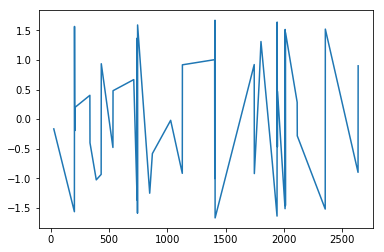

In [41]:
plt.plot(p1_diff.x - p2_diff.x)

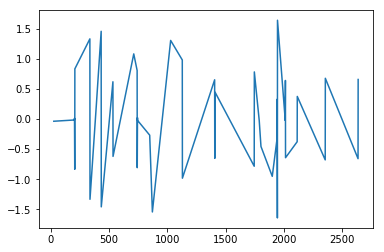

In [42]:
plt.plot(p1_diff.y - p2_diff.y)

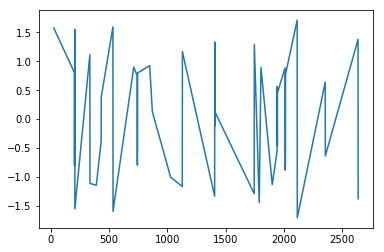

In [43]:
plt.plot(p1_diff.z - p2_diff.z)

#### 3. Difference in partial charges

* Example `3co8A`: One difference (0.001). Negligible. 
* Example `2vouA`: Differences in residues close to missing 320 residue (318, 319, 321). Comprehensibe.

In [44]:
p1_const = p1.iloc[:, [0,2,3,4,5, 11]]
p2_const = p2.iloc[:, [0,2,3,4,5, 11]]

p1_diff = pd.concat([p1_const,p2_const,p2_const]).drop_duplicates(keep=False)
p2_diff = pd.concat([p1_const,p1_const,p2_const]).drop_duplicates(keep=False)

In [45]:
p1_diff

,record_type,atom_name,residue_name,chain_identifier,residue_sequence_number,partial_charges
2978,ATOM,C,GLY,A,318,0.236
2980,ATOM,N,ALA,A,319,-0.347
2982,ATOM,CA,ALA,A,319,0.172
2983,ATOM,C,ALA,A,319,0.240
2984,ATOM,O,ALA,A,319,-0.271
2985,ATOM,CB,ALA,A,319,0.042
2999,ATOM,N,ALA,A,321,-0.346
3001,ATOM,CA,ALA,A,321,0.172
3002,ATOM,C,ALA,A,321,0.240
3004,ATOM,CB,ALA,A,321,0.042


In [46]:
p2_diff

,record_type,atom_name,residue_name,chain_identifier,residue_sequence_number,partial_charges
2978,ATOM,C,GLY,A,318,0.235
2980,ATOM,N,ALA,A,319,-0.349
2982,ATOM,CA,ALA,A,319,0.142
2983,ATOM,C,ALA,A,319,0.255
2984,ATOM,O,ALA,A,319,-0.305
2985,ATOM,CB,ALA,A,319,0.039
2986,ATOM,N,ALA,A,321,-0.067
2990,ATOM,CA,ALA,A,321,0.270
2991,ATOM,C,ALA,A,321,0.248
2993,ATOM,CB,ALA,A,321,0.050


In [47]:
p1_diff.reset_index(drop=True).partial_charges - p2_diff.reset_index(drop=True).partial_charges

0    0.001
1    0.002
2    0.030
3   -0.015
4    0.034
5    0.003
6   -0.279
7   -0.098
8   -0.008
9   -0.008
Name: partial_charges, dtype: float64